In [1]:
import numpy as np
import pandas as pd
# import pyreadr
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.special import expit
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from fairdata import FairData
import gc

## Admission Data

### Data generation

In [2]:
def dat_gen_admission(n, lmbd, intcp, beta_a, beta_s):
    '''Generating admission data.
    
    The sensitive attribute (S) is sex, the only non-sensitive attribute (A) 
    is test score, thus the dimension of a is 1. Test score (A) depends on sex 
    (S) if lmbd is not zero, and the decision (Y) depends on sex (S) if beta_s
    is not zero.
    
    Args:
        n: sample size.
        lmbd: historical disadvantage, male will have higher test score (A) on 
            average if lmbd is positive.
        intcp: intercept in the logistic model for Y.
        beta_a: coefficient of A in the logistic model for Y.
        beta_s: selection bias, male will have a higher probability of 
            admission if beta_s is positive.
        
    Returns:
        A tuple of three numpy.ndarrays (s, a, y).
        
        s: sensitive attributes, numpy.ndarray of size (n, 1).
        a: non-sensitive attributes, numpy.ndarray of size (n, 1).
        y: decisions, numpy.ndarray of size (n, 1).
        
    '''
    s = np.random.binomial(1, p=0.5, size=n)
    eps = np.random.rand(n)
    a = np.clip(lmbd * s + eps, 0, 1)
    y = np.random.binomial(1, p=expit(intcp + beta_a * a + beta_s * s))
    return s.reshape(n, 1), a.reshape(n, 1), y.reshape(n, 1)

In [3]:
np.random.seed(1)
s_train, a_train, y_train = dat_gen_admission(5000, lmbd=0.2, intcp=-1, beta_a=2, beta_s=1)
s_test = np.array([[0], [1], [0]])
a_test = np.array([[0.85], [0.85], [0.65]])
dat = pd.DataFrame({
    'ID':np.arange(1, 5001), 
    'Sex':pd.Categorical(map(lambda x: 'm' if x else 'f', s_train)), 
    'Test':np.round(a_train.squeeze() * 100).astype(np.int), 
    'Admit':pd.Categorical(map(lambda x: 'yes' if x else 'no', y_train))
})
dat

,ID,Sex,Test,Admit
0,1,f,68,no
1,2,m,96,yes
2,3,f,3,yes
3,4,f,98,no
4,5,f,9,no
...,...,...,...,...
4995,4996,f,69,no
4996,4997,m,50,no
4997,4998,f,6,no
4998,4999,m,31,yes


In [46]:
np.load('result/dat_gen_loan_univariate_n5000_marginal_preprocess_acc.npy')

array([[[-1.        ,  2.        ,  1.        ,  0.5       ,
          0.        ,  0.76452   ,  0.76544   ,  0.76037   ,
          0.76034   ,  0.76135   ,  0.76541   ],
        [-1.        ,  2.        ,  1.        ,  0.5       ,
          0.2       ,  0.76474   ,  0.7655    ,  0.75899   ,
          0.75876   ,  0.75876   ,  0.75876   ],
        [-1.        ,  2.        ,  1.        ,  0.5       ,
          0.4       ,  0.76457   ,  0.76473   ,  0.75925   ,
          0.75932   ,  0.75932   ,  0.75932   ],
        [-1.        ,  2.        ,  1.        ,  0.5       ,
          0.6       ,  0.7629    ,  0.76358   ,  0.75745   ,
          0.75743   ,  0.75743   ,  0.75743   ],
        [-1.        ,  2.        ,  1.        ,  0.5       ,
          0.8       ,  0.76566   ,  0.76524   ,  0.75954   ,
          0.75952   ,  0.75952   ,  0.75952   ]],

       [[-1.        ,  2.        ,  1.        ,  0.5       ,
          0.        ,  0.01281365,  0.01275643,  0.01277627,
          0.01282593,

### Decisions on test data

In [4]:
admission = FairData(s_train, a_train, y_train, preprocess_method='m')
y_ml = admission.f_ml(s_test, a_test)
y_eo = admission.f_eo(a_test)
y_aa = admission.f_aa(s_test, a_test)
y_1 = admission.f_1(s_test, a_test)
y_2 = admission.f_2(s_test, a_test)
dat = pd.DataFrame({
    'ID':['A', 'B', 'C'], 
    'Sex':pd.Categorical(map(lambda x: 'm' if x else 'f', s_test)), 
    'Test':np.round(a_test.squeeze() * 100).astype(np.int),
    'y_ml':y_ml, 'y_eo':y_eo, 'y_aa':y_aa, 
    'y_1':y_1, 'y_2':y_2
})
f = 'fair' if admission.cit() > 0.05 else 'not fair'
print('The decisions on the training data is {:s}.'.format(f))
dat

The decisions on the training data is fair.


,ID,Sex,Test,y_ml,y_eo,y_aa,y_1,y_2
0,A,f,85,0.607381,0.704383,0.753499,0.694659,0.697084
1,B,m,85,0.827840,0.704383,0.625893,0.612216,0.614256
2,C,f,65,0.490404,0.604385,0.663253,0.645261,0.647779


In [6]:
admission.pval

0.58

In [7]:
admission.cit(B=99, bootstrap_a_prime=False)

0.61

### Selection bias correction (EO)

In [5]:
M = 100
eo, acc1 = [], []
for _ in range(M):
    eo_metrics, accuracies = [], []
    for beta_s in range(6):
        s, a, y = dat_gen_admission(6000, lmbd=0.2, intcp=-1, beta_a=2, beta_s=beta_s)
        data = FairData(s[:5000], a[:5000], y[:5000])
        eo_metric, accuracy = data.evaluate(s[5000:], a[5000:], y[5000:],
                                            adv=1, dis=0, metrics=['eo', 'acc'])
        eo_metrics.append(eo_metric)
        accuracies.append(accuracy)
    eo.append(eo_metrics)
    acc1.append(accuracies)
eo_mean = np.mean(eo, axis=0)
eo_err = np.std(eo, axis=0)
acc1_mean = np.mean(acc1, axis=0)
acc1_err = np.std(acc1, axis=0)

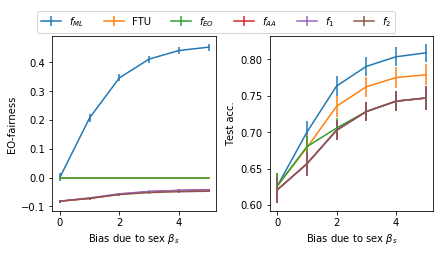

In [6]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

method = ['$f_{ML}$', 'FTU', '$f_{EO}$', '$f_{AA}$', '$f_{1}$', '$f_{2}$']
for i in range(6):
    ax1.errorbar(range(6), eo_mean[:, i], eo_err[:, i], label = method[i])
    ax2.errorbar(range(6), acc1_mean[:, i], acc1_err[:, i])
ax1.set_xlabel("Bias due to sex $\\beta_{s}$")
ax1.set_ylabel("EO-fairness")
ax2.set_xlabel("Bias due to sex $\\beta_{s}$")
ax2.set_ylabel("Test acc.")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=6)
plt.show()

In [7]:
np.round(eo_mean,5)

array([[ 0.00048,  0.     ,  0.     , -0.08187, -0.08187, -0.08209],
       [ 0.20689,  0.     ,  0.     , -0.07266, -0.07072, -0.07201],
       [ 0.34563,  0.     ,  0.     , -0.05798, -0.05627, -0.05896],
       [ 0.41058,  0.     ,  0.     , -0.04902, -0.04831, -0.05224],
       [ 0.44028,  0.     ,  0.     , -0.04463, -0.04463, -0.04916],
       [ 0.45196,  0.     ,  0.     , -0.04225, -0.04258, -0.04743]])

In [8]:
np.round(acc1_mean,5)

array([[0.62536, 0.62564, 0.62567, 0.6205 , 0.6205 , 0.62051],
       [0.69959, 0.67836, 0.67987, 0.6562 , 0.65619, 0.65651],
       [0.76321, 0.73534, 0.70552, 0.70231, 0.70231, 0.70283],
       [0.7902 , 0.76226, 0.72819, 0.72819, 0.72819, 0.72819],
       [0.80339, 0.77482, 0.74244, 0.74244, 0.74244, 0.74244],
       [0.80875, 0.77869, 0.74677, 0.74677, 0.74677, 0.74677]])

### Historical disadvantage correction (AA)

In [9]:
M = 100
aa, acc2 = [], []
for _ in range(M):
    aa_metrics, accuracies = [], []
    for lmbd in np.arange(0, 1, 0.2):
        s, a, y = dat_gen_admission(6000, lmbd=lmbd, intcp=-1, beta_a=2, beta_s=1)
        data = FairData(s[:5000], a[:5000], y[:5000])
        aa_metric, accuracy = data.evaluate(s[5000:], a[5000:], y[5000:],
                                            adv=1, dis=0, metrics=['aa', 'acc'])
        aa_metrics.append(aa_metric)
        accuracies.append(accuracy)
    aa.append(aa_metrics)
    acc2.append(accuracies)
aa_mean = np.mean(aa, axis=0)
aa_err = np.std(aa, axis=0)
acc2_mean = np.mean(acc2, axis=0)
acc2_err = np.std(acc2, axis=0)

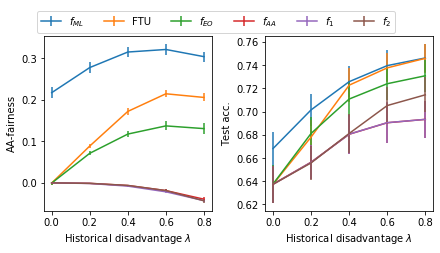

In [10]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

method = ['$f_{ML}$', 'FTU', '$f_{EO}$', '$f_{AA}$', '$f_{1}$', '$f_{2}$']
for i in range(6):
    ax1.errorbar(np.arange(0, 1, 0.2), aa_mean[:, i], aa_err[:, i], label = method[i])
    ax2.errorbar(np.arange(0, 1, 0.2), acc2_mean[:, i], acc2_err[:, i])
ax1.set_xlabel("Historical disadvantage $\\lambda$")
ax1.set_ylabel("AA-fairness")
ax2.set_xlabel("Historical disadvantage $\\lambda$")
ax2.set_ylabel("Test acc.")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=6)
plt.show()

In [11]:
np.round(aa_mean,5)

array([[ 2.1721e-01, -4.0000e-04, -4.4000e-04, -2.0000e-05, -2.0000e-05,
        -2.0000e-05],
       [ 2.7771e-01,  8.8730e-02,  7.1210e-02, -1.1700e-03, -1.4400e-03,
        -1.1400e-03],
       [ 3.1511e-01,  1.7210e-01,  1.1754e-01, -6.3800e-03, -7.8100e-03,
        -6.1400e-03],
       [ 3.2124e-01,  2.1455e-01,  1.3721e-01, -1.8600e-02, -2.1510e-02,
        -1.8580e-02],
       [ 3.0399e-01,  2.0577e-01,  1.3069e-01, -3.9310e-02, -4.2790e-02,
        -4.3170e-02]])

In [12]:
np.round(acc2_mean,5)

array([[0.66813, 0.63737, 0.6376 , 0.63744, 0.63744, 0.63736],
       [0.70141, 0.67805, 0.68116, 0.65639, 0.65627, 0.6558 ],
       [0.72567, 0.72265, 0.71073, 0.68044, 0.6805 , 0.6811 ],
       [0.73948, 0.73754, 0.72391, 0.69031, 0.6904 , 0.70512],
       [0.74607, 0.74576, 0.73075, 0.69324, 0.69324, 0.71435]])

In [13]:
M = 100
aa, acc2 = [], []
for _ in range(M):
    aa_metrics, accuracies = [], []
    for lmbd in np.arange(0, 1, 0.2):
        s, a, y = dat_gen_admission(12000, lmbd=lmbd, intcp=-1, beta_a=2, beta_s=1)
        data = FairData(s[:10000], a[:10000], y[:10000], preprocess_method='m')
        aa_metric, accuracy = data.evaluate(s[10000:], a[10000:], y[10000:],
                                            adv=1, dis=0, metrics=['aa', 'acc'])
        aa_metrics.append(aa_metric)
        accuracies.append(accuracy)
    aa.append(aa_metrics)
    acc2.append(accuracies)
aa_mean = np.mean(aa, axis=0)
aa_err = np.std(aa, axis=0)
acc2_mean = np.mean(acc2, axis=0)
acc2_err = np.std(acc2, axis=0)

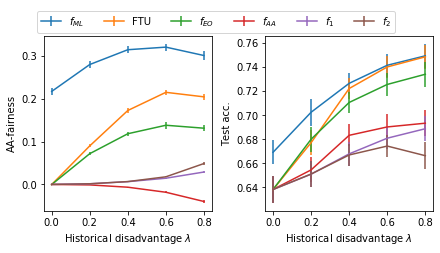

In [14]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

method = ['$f_{ML}$', 'FTU', '$f_{EO}$', '$f_{AA}$', '$f_{1}$', '$f_{2}$']
for i in range(6):
    ax1.errorbar(np.arange(0, 1, 0.2), aa_mean[:, i], aa_err[:, i], label = method[i])
    ax2.errorbar(np.arange(0, 1, 0.2), acc2_mean[:, i], acc2_err[:, i])
ax1.set_xlabel("Historical disadvantage $\\lambda$")
ax1.set_ylabel("AA-fairness")
ax2.set_xlabel("Historical disadvantage $\\lambda$")
ax2.set_ylabel("Test acc.")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=6)
plt.show()

### Fairness test

In [3]:
M = 100
n = 500
pvals = []
for _ in range(M):
    pval = []
    for lb in np.mgrid[0:0.6:0.2,0:3].reshape(2, -1).transpose():
        s, a, y = dat_gen_admission(n, lmbd=lb[0], intcp=-1, beta_a=2, beta_s=lb[1])
        data = FairData(s, a, y)
        pval.append(data.cit())
        gc.collect()
    pvals.append(pval)

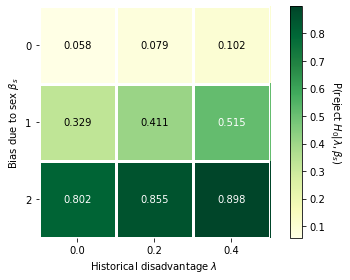

In [41]:
lmbds = np.arange(0, .6, .2)
betas = np.arange(3)
reject = np.array(np.array(pvals) <= 0.05, dtype=np.float)
reject[np.isnan(np.array(pvals))] = None
power = np.nanmean(reject, axis=0).reshape(3, 3)

fig, ax = plt.subplots()
im, cbar = heatmap(power, col_labels=lmbds, row_labels=betas, ax=ax,
                   cmap="YlGn", cbarlabel="P(reject $H_0|\\lambda, \\beta_{s}$)",
                   col_label="Historical disadvantage $\\lambda$",
                   row_label="Bias due to sex $\\beta_{s}$")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()

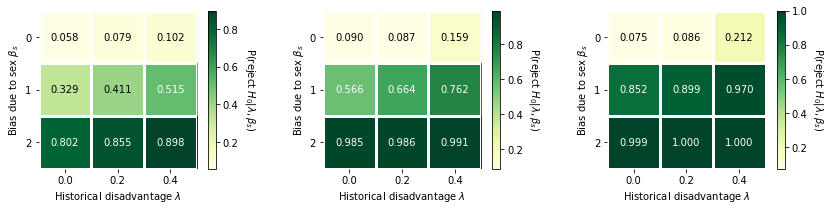

In [139]:
sizes = ['50', '100', '200']
lmbds = np.arange(0, .6, .2)
betas = np.arange(3)

fig, axes = plt.subplots(1, len(sizes), figsize=(4*len(sizes), 3x))
for i, size in enumerate(sizes):
    # read R output from cdcov.test
    result = pyreadr.read_r("pvals_setting1_n"+size+".rds")
    pvals = result[None].to_numpy().reshape(1000,9)
    reject = np.array(pvals <= 0.05, dtype=np.float)
    power = reject.mean(axis=0).reshape(3, 3)
    # plot heatmap
    im, cbar = heatmap(power, col_labels=lmbds, row_labels=betas, ax=axes[i],
                       cmap="YlGn", cbarlabel="P(reject $H_0|\\lambda, \\beta_{s}$)",
                       col_label="Historical disadvantage $\\lambda$",
                       row_label="Bias due to sex $\\beta_{s}$")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()

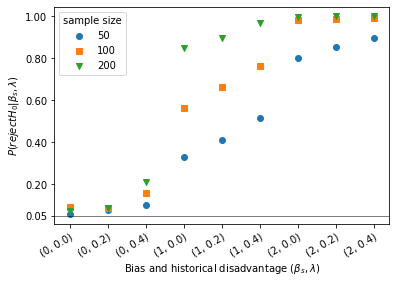

In [11]:
sizes = ['50', '100', '200']
markers = ['o', 's', 'v']
bl = np.mgrid[0:3, 0:0.6:0.2].reshape(2,-1)
beta_s, lmbd = list(bl[0]), list(bl[1])
xlabel = ['({:.0f}, {:.1f})'.format(*p) for p in zip(beta_s, lmbd)]

fig, ax = plt.subplots()
for i, size in enumerate(sizes):
    # read R output from cdcov.test
    result = pyreadr.read_r("pvals_setting1_n"+size+".rds")
    pvals = result[None].to_numpy().reshape(1000,9)
    reject = np.array(pvals <= 0.05, dtype=np.float)
    power = reject.mean(axis=0).flatten()
    ax.scatter(xlabel, power, marker=markers[i], label=size)
ax.axhline(0.05, color='black',linewidth=0.5)
plt.yticks(list(plt.yticks()[0][1:-1]) + [0.05])
ax.set_xlabel("Bias and historical disadvantage $(\\beta_{s}, \\lambda)$")
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor")
ax.set_ylabel("$P(reject H_0|\\beta_{s}, \\lambda$)")
plt.legend(loc='best', title='sample size')
plt.show()

## Loan Data (One Non-sensitive Variable)

### Data generation

In [17]:
def dat_gen_loan1(n, intcp, beta_a, beta_s, lmbd_a, sigma_a=None, 
                 adv_race_proportion=0.7):
    '''Generating loan data.
    
    The sensitive attribute (S) is race, the non-sensitive attribute is 
    log personal income (A). 
    
    A depends on race (S) if lmbd_i and/or sigma_i are not zeros, and the 
    decision (Y) depends on race (S) if beta_s is not zero.
    
    Args:
        n: sample size.
        intcp: intercept in the logistic model for Y.
        beta_a: coefficient of I in the logistic model for Y.
        beta_s: selection biases as an array of numbers, advantageous group 
            (white) will have a higher probability of getting a loan if its 
            corresponding element in beta_s (beta_s[0]) is larger than the 
            elements of the disadvantageous groups (say, beta_s[1] of the 
            black group).
        lmbd_a (float): advantageous group will have higher mean log income if 
            positive.
        sigma_a (float): positive number, the log income of advantageous group 
            will have larger standard deviation if greater than 1.
        adv_race_proportion (float): proportion of the advantageous race group.
        
    Returns:
        A tuple of three numpy.ndarrays (s, a, y).
        
        s: sensitive attributes, numpy.ndarray of size (n, 1).
        a: non-sensitive attributes (E, I), numpy.ndarray of size (n, 2).
        y: decisions, numpy.ndarray of size (n, 1).
        
    '''
    if sigma_a is None:
        sigma_a = 1 + lmbd_a
    # 1: advantageous race, 0: disadvantageous race
    s = np.random.binomial(1, p=adv_race_proportion, size=n)
    i = 4 + lmbd_a * s + 0.2 * sigma_a**s * np.random.randn(n)
    a = np.exp(i)/100
    p = expit(intcp + beta_a * a + beta_s * s)
    y = np.random.binomial(1, p=p)
    
    plt.hist(a * 100000, 50)
    
    return s.reshape(n, 1), a.reshape(n, 1), y.reshape(n, 1)


,ID,Race,Income,Loan
0,1,white,476164,yes
1,2,black,115741,yes
2,3,white,124811,yes
3,4,white,27917,yes
4,5,white,100037,yes
...,...,...,...,...
4995,4996,white,129845,yes
4996,4997,white,758227,yes
4997,4998,white,665582,yes
4998,4999,black,11779,no


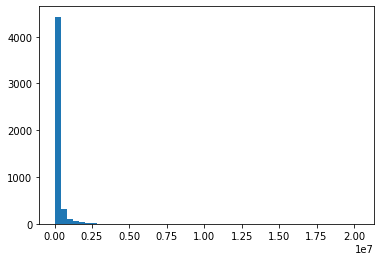

In [18]:
np.random.seed(1)
s_train, a_train, y_train = dat_gen_loan1(5000, intcp=-1, beta_a=2, beta_s=1, lmbd_a=0.5)
s_test = np.array([[0], [1], [0]])
a_test = np.array([[0.85], [0.85], [0.65]])
dat = pd.DataFrame({
    'ID':np.arange(1, 5001), 
    'Race':pd.Categorical(map(lambda x: 'white' if x else 'black', s_train)),
    'Income':np.round(a_train.squeeze() * 100000).astype(np.int), 
    'Loan':pd.Categorical(map(lambda x: 'yes' if x else 'no', y_train))
    
})
dat

### Decisions on test data

In [17]:
loan = FairData(s_train, a_train, y_train, preprocess_method='m')
y_ml = loan.f_ml(s_test, a_test)
y_eo = loan.f_eo(a_test)
y_aa = loan.f_aa(s_test, a_test)
y_1 = loan.f_1(s_test, a_test)
y_2 = loan.f_2(s_test, a_test)
dat = pd.DataFrame({
    'ID':['A', 'B', 'C'], 
    'Race':pd.Categorical(map(lambda x: 'white' if x else 'black', s_test)),
    'LogIncome':a_test.squeeze(), 
    'Income':np.round(np.exp(a_test.squeeze()) * 1000).astype(np.int),
    'y_ml':y_ml, 'y_eo':y_eo, 'y_aa':y_aa, 
    'y_1':y_1, 'y_2':y_2
})
dat

,ID,Race,LogIncome,Income,y_ml,y_eo,y_aa,y_1,y_2
0,A,black,0.85,2340,0.663669,0.788955,0.856518,0.887543,0.885788
1,B,white,0.85,2340,0.842546,0.788955,0.746178,0.739400,0.739817
2,C,black,0.65,1916,0.570178,0.718875,0.803825,0.805399,0.805773


### Historical disadvantage correction (AA)

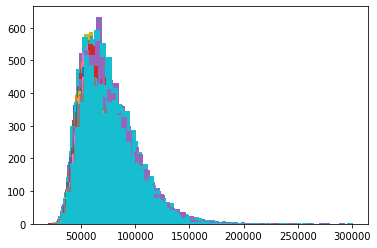

In [18]:
M = 100
aa, acc2 = [], []
for _ in range(M):
    aa_metrics, accuracies = [], []
    for lmbd in np.arange(0, 0.5, 0.1):
        s, a, y = dat_gen_loan1(6000, intcp=-1, beta_a=2, beta_s=1, lmbd_a=lmbd)
        data = FairData(s[:5000], a[:5000], y[:5000])
        aa_metric, accuracy = data.evaluate(s[5000:], a[5000:], y[5000:],
                                            adv=1, dis=0, metrics=['aa', 'acc'])
        aa_metrics.append(aa_metric)
        accuracies.append(accuracy)
    aa.append(aa_metrics)
    acc2.append(accuracies)
aa_mean = np.mean(aa, axis=0)
aa_err = np.std(aa, axis=0)
acc2_mean = np.mean(acc2, axis=0)
acc2_err = np.std(acc2, axis=0)

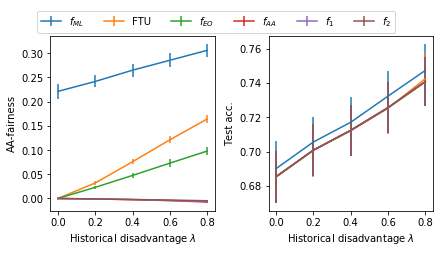

In [19]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

method = ['$f_{ML}$', 'FTU', '$f_{EO}$', '$f_{AA}$', '$f_{1}$', '$f_{2}$']
for i in range(6):
    ax1.errorbar(np.arange(0, 1, 0.2), aa_mean[:, i], aa_err[:, i], label = method[i])
    ax2.errorbar(np.arange(0, 1, 0.2), acc2_mean[:, i], acc2_err[:, i])
ax1.set_xlabel("Historical disadvantage $\\lambda$")
ax1.set_ylabel("AA-fairness")
ax2.set_xlabel("Historical disadvantage $\\lambda$")
ax2.set_ylabel("Test acc.")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=6)
plt.show()

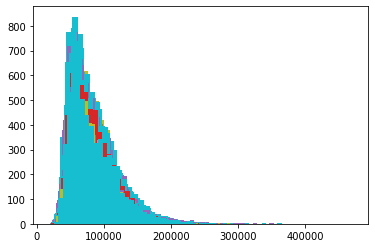

In [20]:
M = 100
aa, acc2 = [], []
for _ in range(M):
    aa_metrics, accuracies = [], []
    for sigma in np.arange(1, 2, 0.2):
        s, a, y = dat_gen_loan1(6000, intcp=-1, beta_a=2, beta_s=1, lmbd_a=0.5, sigma_a=sigma)
        data = FairData(s[:5000], a[:5000], y[:5000], preprocess_method='m')
        aa_metric, accuracy = data.evaluate(s[5000:], a[5000:], y[5000:],
                                            adv=1, dis=0, metrics=['aa', 'acc'])
        aa_metrics.append(aa_metric)
        accuracies.append(accuracy)
    aa.append(aa_metrics)
    acc2.append(accuracies)
aa_mean = np.mean(aa, axis=0)
aa_err = np.std(aa, axis=0)
acc2_mean = np.mean(acc2, axis=0)
acc2_err = np.std(acc2, axis=0)

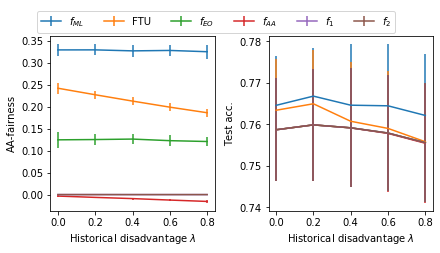

In [21]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

method = ['$f_{ML}$', 'FTU', '$f_{EO}$', '$f_{AA}$', '$f_{1}$', '$f_{2}$']
for i in range(6):
    ax1.errorbar(np.arange(0, 1, 0.2), aa_mean[:, i], aa_err[:, i], label = method[i])
    ax2.errorbar(np.arange(0, 1, 0.2), acc2_mean[:, i], acc2_err[:, i])
ax1.set_xlabel("Historical disadvantage $\\lambda$")
ax1.set_ylabel("AA-fairness")
ax2.set_xlabel("Historical disadvantage $\\lambda$")
ax2.set_ylabel("Test acc.")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=6)
plt.show()

In [22]:
aa_mean

array([[ 3.28857804e-01,  2.41732868e-01,  1.24380839e-01,
        -3.51006303e-03, -1.09431465e-04, -1.08794819e-04],
       [ 3.28947760e-01,  2.26887965e-01,  1.25032711e-01,
        -6.52376546e-03, -1.23797196e-04, -1.23230417e-04],
       [ 3.26677569e-01,  2.12467984e-01,  1.26090376e-01,
        -9.24858355e-03, -1.43912380e-04, -1.43107111e-04],
       [ 3.27637775e-01,  1.98681548e-01,  1.22468162e-01,
        -1.25934687e-02, -1.51148615e-04, -1.50549796e-04],
       [ 3.24737528e-01,  1.85984392e-01,  1.20574492e-01,
        -1.57073645e-02, -1.58300661e-04, -1.57752067e-04]])

### Fairness test

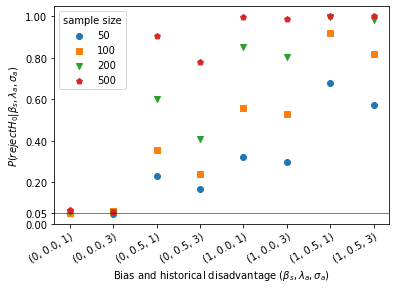

In [14]:
sizes = ['50', '100', '200', '500']
markers = ['o', 's', 'v', 'p']
bsl = np.mgrid[0:2, 1:4:2, 0:1:0.5].reshape(3,-1)
beta_s, sigma, lmbd = list(bsl[0]), list(bsl[1]), list(bsl[2])
xlabel = ['({:.0f}, {:.1f}, {:.0f})'.format(*p) for p in zip(beta_s, lmbd, sigma)]
rearrange = [0,2,1,3,4,6,5,7]

fig, ax = plt.subplots()
for i, size in enumerate(sizes):
    # read R output from cdcov.test
    result = pyreadr.read_r("pvals_setting2_n"+size+".rds")
    pvals = result[None].to_numpy().reshape(1000,8)
    reject = np.array(pvals <= 0.05, dtype=np.float)
    power = reject.mean(axis=0).flatten()
    ax.scatter([xlabel[idx] for idx in rearrange], power[rearrange], marker=markers[i], label=size)
ax.axhline(0.05, color='black',linewidth=0.5)
plt.yticks(list(plt.yticks()[0][1:-1]) + [0.05])
ax.set_xlabel("Bias and historical disadvantage $(\\beta_{s}, \\lambda_{a}, \\sigma_{a})$")
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor")
ax.set_ylabel("$P(reject H_0|\\beta_{s}, \\lambda_{a}, \\sigma_{a}$)")
plt.legend(loc='best', title='sample size')
plt.show()

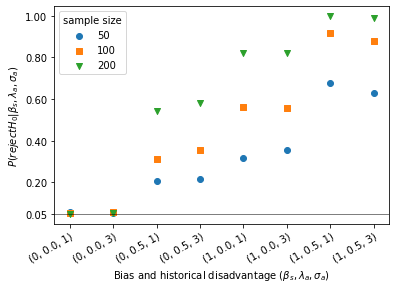

In [15]:
sizes = ['50', '100', '200']
markers = ['o', 's', 'v', 'p']
bsl = np.mgrid[0:2, 1:4:2, 0:1:0.5].reshape(3,-1)
beta_s, sigma, lmbd = list(bsl[0]), list(bsl[1]), list(bsl[2])
xlabel = ['({:.0f}, {:.1f}, {:.0f})'.format(*p) for p in zip(beta_s, lmbd, sigma)]
rearrange = [0,2,1,3,4,6,5,7]

fig, ax = plt.subplots()
for i, size in enumerate(sizes):
    # read R output from cdcov.test
    result = pyreadr.read_r("pvals_setting2_n"+size+"_true.rds")
    pvals = result[None].to_numpy().reshape(1000,8)
    reject = np.array(pvals <= 0.05, dtype=np.float)
    power = reject.mean(axis=0).flatten()
    ax.scatter([xlabel[idx] for idx in rearrange], power[rearrange], marker=markers[i], label=size)
ax.axhline(0.05, color='black',linewidth=0.5)
plt.yticks(list(plt.yticks()[0][1:-1]) + [0.05])
ax.set_xlabel("Bias and historical disadvantage $(\\beta_{s}, \\lambda_{a}, \\sigma_{a})$")
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor")
ax.set_ylabel("$P(reject H_0|\\beta_{s}, \\lambda_{a}, \\sigma_{a}$)")
plt.legend(loc='best', title='sample size')
plt.show()

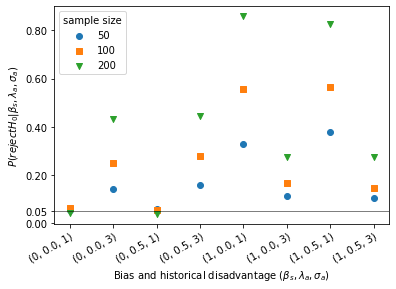

In [16]:
sizes = ['50', '100', '200']
markers = ['o', 's', 'v', 'p']
bsl = np.mgrid[0:2, 1:4:2, 0:1:0.5].reshape(3,-1)
beta_s, sigma, lmbd = list(bsl[0]), list(bsl[1]), list(bsl[2])
xlabel = ['({:.0f}, {:.1f}, {:.0f})'.format(*p) for p in zip(beta_s, lmbd, sigma)]
rearrange = [0,2,1,3,4,6,5,7]

fig, ax = plt.subplots()
for i, size in enumerate(sizes):
    # read R output from cdcov.test
    result = pyreadr.read_r("pvals_setting3_n"+size+".rds")
    pvals = result[None].to_numpy().reshape(1000,8)
    reject = np.array(pvals <= 0.05, dtype=np.float)
    power = reject.mean(axis=0).flatten()
    ax.scatter([xlabel[idx] for idx in rearrange], power[rearrange], marker=markers[i], label=size)
ax.axhline(0.05, color='black',linewidth=0.5)
plt.yticks(list(plt.yticks()[0][1:-1]) + [0.05])
ax.set_xlabel("Bias and historical disadvantage $(\\beta_{s}, \\lambda_{a}, \\sigma_{a})$")
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor")
ax.set_ylabel("$P(reject H_0|\\beta_{s}, \\lambda_{a}, \\sigma_{a}$)")
plt.legend(loc='best', title='sample size')
plt.show()

In [6]:
power

array([0.063, 0.904, 0.054, 0.78 , 0.997, 1.   , 0.988, 1.   ])

## Loan Data (Two Non-sensitive Variables)

### Data generation

In [13]:
def dat_gen_loan(n, beta_e, beta_i, beta_s, race_proportion=None,
                 race_mean_edu=None, race_med_income=None):
    '''Generating loan data.
    
    The sensitive attribute (S) is race, the non-sensitive attributes are 
    education years (E) and personal income (I), thus the dimension of a is 2. 
    
    E and I depend on race (S) if lmbd_e and lmbd_i are not zeros, and the 
    decision (Y) depends on sex (S) if beta_s is not zero.
    
    Args:
        n: sample size.
        beta_e: coefficient of E in the logistic model for Y.
        beta_i: coefficient of I in the logistic model for Y.
        beta_s: selection biases as an array of numbers, advantage group 
            (white) will have a higher probability of getting a loan if its 
            corresponding element in beta_s (beta_s[0]) is larger than the 
            elements of the disadvantage groups (say, beta_s[1] of the black
            group).
        race_proportion: proportion of white, black, asian people as an array 
            of float numbers.
        race_mean_edu: mean education time (10 year) by race.
        race_med_income: median annual income (100,000 dollars) by race.
        
    Returns:
        A tuple of three numpy.ndarrays (s, a, y).
        
        s: sensitive attributes, numpy.ndarray of size (n, 1).
        a: non-sensitive attributes (E, I), numpy.ndarray of size (n, 2).
        y: decisions, numpy.ndarray of size (n, 1).
        
    '''
    if race_proportion is None:
        race_proportion = np.array([0.76, 0.16, 0.08])
    else:
        race_proportion = np.array(race_proportion)
    if race_mean_edu is None:
        race_mean_edu = np.array([1.07, 0.99, 1.26])
    else:
        race_mean_edu = np.array(race_mean_edu)
    if race_med_income is None:
        race_med_income = np.array([0.58, 0.40, 0.81])
    else:
        race_med_income = np.array(race_med_income)
    assert race_proportion.ndim == 1 and \
        race_proportion.shape == race_mean_edu.shape == race_med_income.shape
    
    beta_s = np.array(beta_s)
    assert beta_s.ndim == 1 and beta_s.shape == race_proportion.shape
    
    # onehot encoded s
    s_onehot = np.random.multinomial(1, pvals=race_proportion, size=n)
    # s as labels
    s = np.argmax(s_onehot, axis=1)
    # education years e = e_mean + e_eps
    e_mean = race_mean_edu.take(s)
    e_sd = np.min(race_mean_edu) / 2.5
    e_eps = np.random.normal(0, e_sd, size=n)
    e = np.clip(e_mean + e_eps, 0, None)
    # income log(i) = log(i_med) + e_eps + i_eps
    i_med = race_med_income.take(s)
    i_mu = np.log(i_med) + e_eps
    i = np.random.lognormal(i_mu, 0.1)
    # conditional expectation of y
    p = expit(beta_e * e + beta_i * i + beta_s.take(s))
    y = np.random.binomial(1, p=p)
    # non-sensitive attributes
    a = np.column_stack((e, i))
    return s.reshape(n, 1), a, y.reshape(n, 1)


In [14]:
np.random.seed(1)
race_label = {0:'white', 1:'black', 2:'asian'}
s_train, a_train, y_train = dat_gen_loan(5000, beta_e=1, beta_i=2, beta_s=[-1.5,-2.5,-1.5])
s_test = np.array([[0], [1], [1]])
a_test = np.array([[1.6, 0.8], [1.2, 0.8], [1.6, 0.8]])
dat = pd.DataFrame({
    'ID':np.arange(1, 5001), 
    'Race':pd.Categorical(map(lambda x: race_label[x.item()], s_train)), 
    'EduYear':np.round(a_train[:, 0] * 10).astype(np.int),
    'Income':np.round(a_train[:, 1] * 100000).astype(np.int), 
    'Loan':pd.Categorical(map(lambda x: 'yes' if x else 'no', y_train))
})
dat

,ID,Race,EduYear,Income,Loan
0,1,white,9,44297,no
1,2,white,5,35670,yes
2,3,white,13,78278,yes
3,4,white,17,125337,yes
4,5,white,10,55259,no
...,...,...,...,...,...
4995,4996,black,15,66499,yes
4996,4997,asian,17,120744,yes
4997,4998,white,7,41786,no
4998,4999,black,10,43273,no


### Decisions on test data

In [15]:
loan = FairData(s_train, a_train, y_train, preprocess_method='m')
y_ml = loan.f_ml(s_test, a_test)
y_eo = loan.f_eo(a_test)
y_aa = loan.f_aa(s_test, a_test)
y_1 = loan.f_1(s_test, a_test)
y_2 = loan.f_2(s_test, a_test)
dat = pd.DataFrame({
    'ID':['A', 'B', 'C'], 
    'Race':pd.Categorical(map(lambda x: race_label[x.item()], s_test)), 
    'EduYear':np.round(a_test[:, 0] * 10).astype(np.int),
    'Income':np.round(a_test[:, 1] * 100000).astype(np.int), 
    'y_ml':y_ml, 'y_eo':y_eo, 'y_aa':y_aa, 
    'y_1':y_1, 'y_2':y_2
})
dat

,ID,Race,EduYear,Income,y_ml,y_eo,y_aa,y_1,y_2
0,A,white,16,80000,0.845031,0.814943,0.808708,0.800011,0.801035
1,B,black,12,80000,0.576800,0.753346,0.818643,0.856596,0.856429
2,C,black,16,80000,0.665384,0.814943,0.866707,0.901809,0.901357


### Selection bias correction (EO)

In [16]:
M = 100
eo, acc1 = [], []
for _ in range(M):
    eo_metrics, accuracies = [], []
    for beta_s_diff in range(6):
        beta_s = [-2.5 + beta_s_diff, -2.5]
        s, a, y = dat_gen_loan(6000, beta_e=1, beta_i=2, beta_s=beta_s,
                               race_proportion = np.array([0.76, 0.24]),
                               race_mean_edu = np.array([1.07, 0.99]),
                               race_med_income = np.array([0.58, 0.40]))
        data = FairData(s[:5000], a[:5000], y[:5000])
        eo_metric, accuracy = data.evaluate(s[5000:], a[5000:], y[5000:],
                                            adv=0, dis=1, metrics=['eo', 'acc'])
        eo_metrics.append(eo_metric)
        accuracies.append(accuracy)
    eo.append(eo_metrics)
    acc1.append(accuracies)
eo_mean = np.mean(eo, axis=0)
eo_err = np.std(eo, axis=0)
acc1_mean = np.mean(acc1, axis=0)
acc1_err = np.std(acc1, axis=0)

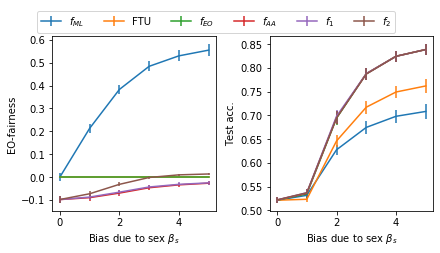

In [17]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

method = ['$f_{ML}$', 'FTU', '$f_{EO}$', '$f_{AA}$', '$f_{1}$', '$f_{2}$']
for i in range(6):
    ax1.errorbar(range(6), eo_mean[:, i], eo_err[:, i], label = method[i])
    ax2.errorbar(range(6), acc1_mean[:, i], acc1_err[:, i])
ax1.set_xlabel("Bias due to sex $\\beta_{s}$")
ax1.set_ylabel("EO-fairness")
ax2.set_xlabel("Bias due to sex $\\beta_{s}$")
ax2.set_ylabel("Test acc.")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=6)
plt.show()

### Historical disadvantage correction (AA)

In [18]:
M = 100
aa, cf, acc2 = [], [], []
for _ in range(M):
    aa_metrics, cf_metrics, accuracies = [], [], []
    for edu_diff in np.arange(0, 0.5, 0.1):
        race_mean_edu = [0.99 + edu_diff, 0.99]
        s, a, y = dat_gen_loan(6000, beta_e=1, beta_i=2, beta_s=[-1.5, -2.5],
                               race_proportion = np.array([0.76, 0.24]),
                               race_mean_edu = race_mean_edu,
                               race_med_income = np.array([0.58, 0.40]))
        data = FairData(s[:5000], a[:5000], y[:5000])
        aa_met, cf_met, accuracy = data.evaluate(s[5000:], a[5000:], y[5000:], 
                                                 adv=0, dis=1, metrics=['aa', 'cf', 'acc'])
        aa_metrics.append(aa_met)
        cf_metrics.append(cf_met)
        accuracies.append(accuracy)
    aa.append(aa_metrics)
    cf.append(cf_metrics)
    acc2.append(accuracies)
aa_mean = np.mean(aa, axis=0)
aa_err = np.std(aa, axis=0)
cf_mean = np.mean(cf, axis=0)
cf_err = np.std(cf, axis=0)
acc2_mean = np.mean(acc2, axis=0)
acc2_err = np.std(acc2, axis=0)

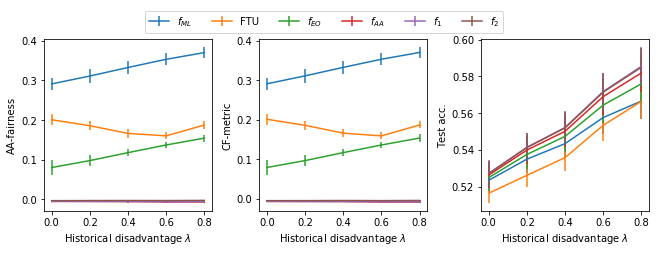

In [19]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

method = ['$f_{ML}$', 'FTU', '$f_{EO}$', '$f_{AA}$', '$f_{1}$', '$f_{2}$']
for i in range(6):
    ax1.errorbar(np.arange(0, 1, 0.2), aa_mean[:, i], aa_err[:, i], label = method[i])
    ax2.errorbar(np.arange(0, 1, 0.2), cf_mean[:, i], cf_err[:, i])
    ax3.errorbar(np.arange(0, 1, 0.2), acc2_mean[:, i], acc2_err[:, i])
ax1.set_xlabel("Historical disadvantage $\\lambda$")
ax1.set_ylabel("AA-fairness")
ax2.set_xlabel("Historical disadvantage $\\lambda$")
ax2.set_ylabel("CF-metric")
ax3.set_xlabel("Historical disadvantage $\\lambda$")
ax3.set_ylabel("Test acc.")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=6)
plt.show()

In [20]:
aa_mean

array([[ 0.29135113,  0.20059898,  0.07976765, -0.00601407, -0.00580023,
        -0.004158  ],
       [ 0.31120761,  0.18548009,  0.09723546, -0.00615797, -0.00587696,
        -0.00394229],
       [ 0.33288373,  0.16605404,  0.11739259, -0.00646886, -0.0060892 ,
        -0.00375193],
       [ 0.35360066,  0.15980648,  0.13676221, -0.0073668 , -0.00681387,
        -0.00392384],
       [ 0.37053656,  0.18722746,  0.1541533 , -0.0072205 , -0.00658067,
        -0.00348722]])

In [21]:
M = 100
aa, cf, acc2 = [], [], []
for _ in range(M):
    aa_metrics, cf_metrics, accuracies = [], [], []
    for edu_diff in np.arange(0, 0.5, 0.1):
        race_mean_edu = [0.99 + edu_diff, 0.99]
        s, a, y = dat_gen_loan(6000, beta_e=1, beta_i=2, beta_s=[-1.5, -2.5],
                               race_proportion = np.array([0.76, 0.24]),
                               race_mean_edu = race_mean_edu,
                               race_med_income = np.array([0.58, 0.40]))
        data = FairData(s[:5000], a[:5000], y[:5000], preprocess_method='m')
        aa_met, cf_met, accuracy = data.evaluate(s[5000:], a[5000:], y[5000:], 
                                                 adv=0, dis=1, metrics=['aa', 'cf', 'acc'])
        aa_metrics.append(aa_met)
        cf_metrics.append(cf_met)
        accuracies.append(accuracy)
    aa.append(aa_metrics)
    cf.append(cf_metrics)
    acc2.append(accuracies)
aa_mean = np.mean(aa, axis=0)
aa_err = np.std(aa, axis=0)
cf_mean = np.mean(cf, axis=0)
cf_err = np.std(cf, axis=0)
acc2_mean = np.mean(acc2, axis=0)
acc2_err = np.std(acc2, axis=0)

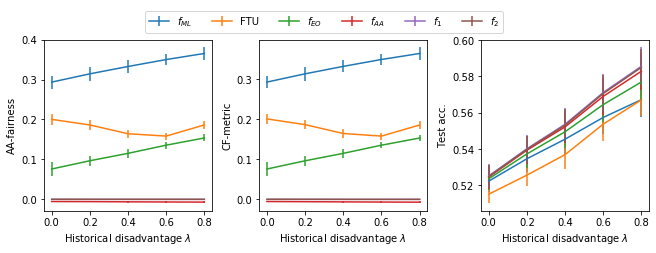

In [22]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

method = ['$f_{ML}$', 'FTU', '$f_{EO}$', '$f_{AA}$', '$f_{1}$', '$f_{2}$']
for i in range(6):
    ax1.errorbar(np.arange(0, 1, 0.2), aa_mean[:, i], aa_err[:, i], label = method[i])
    ax2.errorbar(np.arange(0, 1, 0.2), cf_mean[:, i], cf_err[:, i])
    ax3.errorbar(np.arange(0, 1, 0.2), acc2_mean[:, i], acc2_err[:, i])
ax1.set_xlabel("Historical disadvantage $\\lambda$")
ax1.set_ylabel("AA-fairness")
ax2.set_xlabel("Historical disadvantage $\\lambda$")
ax2.set_ylabel("CF-metric")
ax3.set_xlabel("Historical disadvantage $\\lambda$")
ax3.set_ylabel("Test acc.")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=6)
plt.show()

In [23]:
aa_mean

array([[ 2.93816646e-01,  2.00301205e-01,  7.57521432e-02,
        -5.90621725e-03, -3.44537536e-04, -3.41439912e-04],
       [ 3.14601002e-01,  1.86259739e-01,  9.64448023e-02,
        -6.16483020e-03, -3.75050476e-04, -3.70413344e-04],
       [ 3.33022397e-01,  1.64212379e-01,  1.15039189e-01,
        -6.62534889e-03, -3.82289866e-04, -3.76505272e-04],
       [ 3.50423027e-01,  1.58331792e-01,  1.35537206e-01,
        -7.03998225e-03, -3.95273175e-04, -3.87829294e-04],
       [ 3.65697566e-01,  1.86331914e-01,  1.53626276e-01,
        -7.38091897e-03, -3.97887040e-04, -3.89024393e-04]])

## Utility

In [38]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", row_label="", col_label="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.set_xlabel(col_label)
    ax.set_ylabel(row_label)

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(np.nanmax(data))/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] is np.ma.masked:
                text = im.axes.text(j, i, 'None', **kw)
            else:
                kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts